In [ ]:
import sys
print(sys.version)

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


In [ ]:
!pip install fastai

In [ ]:
pip install efficientnet-pytorch

In [ ]:
import fastai
print(fastai.__version__)  # Check the installed version

2.7.18


In [ ]:
# Import required libraries
from fastai.vision.all import *
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Input: Image, Target: Category
    get_items=get_image_files,  # Get all image files in the path
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Train/valid split
    get_y=parent_label,  # Labels from parent folder names
    item_tfms=Resize(460),  # Resize to 460 before batching
    batch_tfms=aug_transforms(size=224)  # Resize to 224 with augmentations
)

# Load the DataLoaders
path = Path('data/train15')
dls = dblock.dataloaders(path, bs=8, num_workers=0)




# Show a batch of images
# dls.show_batch(max_n=9, figsize=(8, 8))

In [ ]:
#Later on set as a function - Hard coded from the excel train 2015 Let's say these are the sample counts for each class
class_counts = [25810, 2443, 5292, 873, 708]  # Replace with your actual class distribution
# Compute weights inversely proportional to class frequency
class_weights = [1.0 / count for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
class CustomModelMethods:
    """CustomModelMethods is a base class that defines methods for training and evaluating a model using FastAI."""

    def __init__(self):
        # Initialize without any learner
        self.class_learner = None

    def get_learner(self, dls, criterion, metrics):
        """Initializes a FastAI Learner with a given dataset, criterion, and metrics."""
        if self.class_learner is None:  # If learner doesn't exist, create one
            self.class_learner = Learner(dls, self, loss_func=criterion, metrics=metrics)
        return self.class_learner  # Return the initialized learner

    def train_model(self, dls, epochs=10, criterion=None, early_stopping=None):
        """Trains the model using FastAI Learner's fine_tune method for transfer learning or training from scratch."""
        if self.class_learner is None:  # Create learner if not already initialized
            # Initialize Learner with loss function
            self.class_learner = Learner(dls, self, loss_func=criterion, metrics=accuracy)
            self.class_learner.create_opt()  # Create the optimizer

        # Train for the specified number of epochs
        for epoch in range(epochs):
            train_loss = self.class_learner.fit_one_cycle(1)  # Train for one epoch
            val_loss = self.class_learner.validate()[0]  # Get validation loss
            print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

            # Check for early stopping
            if early_stopping and early_stopping(val_loss):
                print(f"Early stopping triggered after epoch {epoch + 1}.")
                break  # Exit training loop if early stopping is triggered

    def evaluate_model(self, dls):
        """Evaluates the model: generates confusion matrix, displays top losses, and calculates accuracy."""
        print("Using validation DataLoader for evaluation.")
        print(f"Validation DataLoader size: {len(dls.valid)}")

        if self.class_learner is None:
            self.class_learner = Learner(dls.valid, self, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

        # Check dataset sizes during evaluation
        print(f"Validation dataset size: {len(dls.valid_ds)}")
        print(f"Training dataset size: {len(dls.train_ds)}")

        # Print DataLoader sizes
        print(f"Training DataLoader size: {len(dls.train)}")
        print(f"Validation DataLoader size: {len(dls.valid)}")

        # Validate structure of the validation dataset
        print("Validating the structure of the validation dataset...")
        print(f"Sample validation data (first 5 items): {dls.valid_ds.items[:5]}")  # Print first 5 items

        # Correctly access the validation labels
        labels = [item[1] for item in dls.valid_ds.items]  # Assuming the second element is the label
        print(f"Sample validation labels (first 5): {labels[:5]}")  # Print first 5 labels

        # Generate metrics like confusion matrix and top losses
        interp = ClassificationInterpretation.from_learner(self.class_learner)

        # Get predictions and targets
        preds, targets = self.class_learner.get_preds(ds_idx=1)  # Ensures we use validation set

        # Check for any mismatch in lengths
        if preds.size(0) != targets.size(0):
            print(f"Mismatch detected! Predictions: {preds.size(0)}, Targets: {targets.size(0)}")
            # Truncate predictions or targets to the smaller size
            min_size = min(preds.size(0), targets.size(0))
            preds = preds[:min_size]
            targets = targets[:min_size]
            print(f"Using truncated sizes: {preds.size(0)} for both predictions and targets.")

        # Print the shape of the predictions and targets to diagnose any mismatch
        print(f"Shape of predictions: {preds.shape}")
        print(f"Shape of targets: {targets.shape}")

        # Print the first few predictions and targets for a quick sanity check
        print(f"Sample predictions: {preds[:10]}")
        print(f"Sample targets: {targets[:10]}")

        preds = torch.argmax(preds, dim=1)

        # Check for unique classes in targets and preds
        unique_targets = set(targets.numpy())
        unique_preds = set(preds.numpy())

        if len(unique_targets) == 0 or len(unique_preds) == 0:
            print("Warning: No valid classes present in targets or predictions.")
        else:
            print(f"Accuracy: {accuracy_score(targets, preds):.4f}")
            print('Classification Report:')
            print(classification_report(targets, preds, zero_division=0))  # Adjust zero_division as needed
            print('Confusion Matrix:')
            print(confusion_matrix(targets, preds))

            # Micro and Macro metrics
            micro_precision = precision_score(targets, preds, average='micro')
            micro_recall = recall_score(targets, preds, average='micro')
            micro_f1 = f1_score(targets, preds, average='micro')

            macro_precision = precision_score(targets, preds, average='macro')
            macro_recall = recall_score(targets, preds, average='macro')
            macro_f1 = f1_score(targets, preds, average='macro')

            print("\nMicro and Macro Averages:")
            print(f"Micro Precision: {micro_precision:.4f}")
            print(f"Micro Recall: {micro_recall:.4f}")
            print(f"Micro F1 Score: {micro_f1:.4f}")
            print(f"Macro Precision: {macro_precision:.4f}")
            print(f"Macro Recall: {macro_recall:.4f}")
            print(f"Macro F1 Score: {macro_f1:.4f}")

    def save_model(self, filename, mode='weights', pretrained_pkl_path=None):
        """Saves the model weights to the specified file or directory using Hugging Face's save_pretrained method."""
        if mode == 'weights':
            if hasattr(self.class_learner.model, 'save_pretrained'):
                #Issue fix: Using Hugging Face's save_pretrained method
                self.class_learner.model.save_pretrained(filename)  # Use Hugging Face method
                print(f"Hugging Face method - Model weights saved to {filename}.")
            else:
                torch.save(self.class_learner.model.state_dict(), filename)  # Fallback for non-Hugging Face models
                print(f"Model weights saved to {filename}.")
        elif mode == 'full':
            torch.save(self.class_learner, filename)
            print(f"Full model saved to {filename}.")
        else:
            raise ValueError("Invalid mode. Use 'full' or 'weights'.")

        # Export to pickle file from the learner
        if pretrained_pkl_path is not None:
            #Issue fix: Ensure compatibility with Hugging Face models
            self.class_learner.export(pretrained_pkl_path)
            print(f"Learner exported to {pretrained_pkl_path}.")

    def load_model(self, filename, mode='full'):
        """Loads the model weights or the full model from the specified file."""
        try:
            if filename.endswith('.pth') or filename.endswith('.pt'):
                if mode == 'weights':
                    self.class_learner.model.load_state_dict(torch.load(filename))
                    print(f"Model weights loaded from {filename}.")
                elif mode == 'full':
                    self.class_learner = torch.load(filename)  # Load the entire model
                    print(f"Full model loaded from {filename}.")
                else:
                    raise ValueError("Invalid mode. Use 'full' or 'weights'.")
            elif filename.endswith('.pkl'):
                self.class_learner = torch.load(filename)  # Load the entire learner from the pickle file
                print(f"Full model loaded from {filename}.")
            else:
                raise ValueError("Unsupported file extension. Use .pth, .pt, or .pkl.")

        except Exception as e:
            if mode == 'weights':
                #Issue fix: Attempt loading weights with strict=False for compatibility
                self.class_learner.model.load_state_dict(torch.load(filename, strict=False))
                print(f"Model weights loaded with strict=False from {filename}. Warning: {e}")
            elif mode == 'full':
                self.class_learner = torch.load(filename, strict=False)
                print(f"Full model loaded with strict=False from {filename}. Warning: {e}")
            else:
                print(f"An error occurred: {e}. Invalid mode. Use 'full' or 'weights'.")


In [ ]:
class PretrainedEyeDiseaseClassifier(nn.Module, CustomModelMethods):
    """A pretrained model for classifying eye diseases using transfer learning. Supports VGG16, ResNet18, or EfficientNet-B7."""

    def __init__(self, num_classes=5, pretrained_model='vgg16'):
        nn.Module.__init__(self)  # Initialize PyTorch's nn.Module
        CustomModelMethods.__init__(self)  # Initialize methods for training/evaluation from the CustomModelMethods class
        print("Initializing PretrainedEyeDiseaseClassifier...")

        # Initialize num_ftrs as an instance variable
        self.num_ftrs = None

        # Choose between VGG16, ResNet18, or EfficientNet-B7 pretrained models
        if pretrained_model == 'vgg16':
            self.model = models.vgg16(pretrained=True)  # Load pretrained VGG16 model
            self.num_ftrs = 4096  # Set num_ftrs for VGG16
            self.model.classifier[6] = nn.Linear(self.num_ftrs, num_classes)  # Replace final layer for `num_classes`
            print("Using VGG16 model.")
        elif pretrained_model == 'resnet18':
            self.model = models.resnet18(pretrained=True)  # Load pretrained ResNet18 model
            self.num_ftrs = self.model.fc.in_features  # Get the number of input features for the final layer
            self.model.fc = nn.Linear(self.num_ftrs, num_classes)  # Replace final layer with a custom one
            print("Using ResNet18 model.")
        elif pretrained_model == 'efficientnet-b7':
            self.model = EfficientNet.from_pretrained('efficientnet-b7')  # Load pretrained EfficientNet-B7 model
            self.num_ftrs = self.model._fc.in_features  # Get the number of input features for the final layer
            self.model._fc = nn.Linear(self.num_ftrs, num_classes)  # Replace final layer with a custom one
            print("Using EfficientNet-B7 model.")
        else:
            raise ValueError("Unsupported pretrained model. Choose 'vgg16', 'resnet18', or 'efficientnet-b7'.")

    def create_fc_layers(self, num_classes, num_ftrs):
        """Creates custom fully connected layers connected to the pretrained model's output."""
        print("Creating fully connected layers...")
        return nn.Sequential(
            nn.Linear(num_ftrs, 512),  # First fully connected layer
            nn.ReLU(),  # Activation function
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(512, 256),  # Second fully connected layer
            nn.ReLU(),  # Activation function
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(256, num_classes)  # Final layer for classification
        )

    def forward(self, x):
        """Forward pass for the model, which applies the pretrained model's forward pass.
        every batch processed during training or validation calls the forward method,
        and you have a print statement inside that method. so comment it
        """

        ##print("Performing forward pass...")
        x = self.model(x)  # Pass input through the model
        return x  # Return the output from the model

    def set_num_classes(self, num_classes):
        """Dynamically adjust the final layer to accommodate a new number of classes."""
        print("Setting number of classes...")
        if isinstance(self.model, models.VGG):
            self.model.classifier[6] = nn.Linear(self.num_ftrs, num_classes)  # Update VGG final layer
        elif isinstance(self.model, models.ResNet):
            self.model.fc = nn.Linear(self.num_ftrs, num_classes)  # Update ResNet final layer
        elif isinstance(self.model, EfficientNet):
            self.model._fc = nn.Linear(self.num_ftrs, num_classes)  # Update EfficientNet final layer

        print(f"Number of classes updated to {num_classes}.")  # Confirmation message

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Custom precision with zero_division handling for macro average
def precision_macro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return precision_score(targs, preds, average='macro', zero_division=1)

def precision_micro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return precision_score(targs, preds, average='micro', zero_division=1)

# Custom recall with zero_division handling for macro average
def recall_macro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return recall_score(targs, preds, average='macro', zero_division=1)

def recall_micro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return recall_score(targs, preds, average='micro', zero_division=1)

# Custom f1 score with zero_division handling for macro average
def f1score_macro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return f1_score(targs, preds, average='macro', zero_division=1)

def f1score_micro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return f1_score(targs, preds, average='micro', zero_division=1)

In [ ]:
class EarlyStopping:
    """
    EarlyStopping monitors the validation loss during training and stops the training process
    if the loss does not improve after a specified number of epochs (patience).

    Attributes:
    - patience: The number of epochs to wait for improvement before stopping.
    - min_delta: Minimum change in the monitored quantity to qualify as an improvement.
    - counter: Counts the number of epochs without improvement.
    - best_loss: Stores the best validation loss encountered during training.
    - stopped_epoch: Records the epoch number when training was stopped.
    """

    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.stopped_epoch = 0

    def __call__(self, val_loss):
        """
        Checks the validation loss to determine if training should stop.

        Parameters:
        - val_loss: The current validation loss to check against the best loss.

        Returns:
        - bool: True if training should stop, otherwise False.
        """
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if there's improvement
        else:
            self.counter += 1  # Increment counter if no improvement

        if self.counter >= self.patience:
            self.stopped_epoch = self.counter
            return True  # Stop training

        return False  # Continue training


In [ ]:
# Initialize the Model
model = PretrainedEyeDiseaseClassifier(pretrained_model='efficientnet-b7', num_classes=5)

early_stopping = EarlyStopping(patience=5)

Initializing PretrainedEyeDiseaseClassifier...


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:04<00:00, 55.0MB/s]


Loaded pretrained weights for efficientnet-b7
Using EfficientNet-B7 model.


In [ ]:
# Create the FAST AI Learner
learn = Learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=partial(Adam, lr=0.001),
    metrics=[
        accuracy,
        precision_micro, recall_micro, f1score_micro,
        precision_macro, recall_macro, f1score_macro
    ]
)


learn.create_opt()
# Train the Model
epochs= 10
for epoch in range(epochs):
    # Train for one epoch
    learn.fit_one_cycle(1)

    # Get training loss directly from the recorder
    train_loss = learn.recorder.values[-1][0] if learn.recorder.values else 'N/A'


    val_loss = learn.validate()[0]  # Get validation loss
    # Print training and validation losses if available, otherwise indicate 'N/A'
    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss}, Validation Loss: {val_loss:.4f}")

    # Check for early stopping
    if early_stopping and early_stopping(val_loss):
        print(f"Early stopping triggered after epoch {epoch + 1}.")
        break  # Exit training loop if early stopping is triggered

epoch,train_loss,valid_loss,accuracy,precision_micro,recall_micro,f1score_micro,precision_macro,recall_macro,f1score_macro,time
0,1.530212,1.604937,0.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.000000,00:20


Epoch [1/10], Train Loss: 1.5302115678787231, Validation Loss: 1.6049


epoch,train_loss,valid_loss,accuracy,precision_micro,recall_micro,f1score_micro,precision_macro,recall_macro,f1score_macro,time
0,1.624650,1.601491,0.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.000000,00:23


Epoch [2/10], Train Loss: 1.6246497631072998, Validation Loss: 1.6015


epoch,train_loss,valid_loss,accuracy,precision_micro,recall_micro,f1score_micro,precision_macro,recall_macro,f1score_macro,time
0,1.605915,1.597662,0.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.000000,00:19


Epoch [3/10], Train Loss: 1.6059153079986572, Validation Loss: 1.5977


epoch,train_loss,valid_loss,accuracy,precision_micro,recall_micro,f1score_micro,precision_macro,recall_macro,f1score_macro,time
0,1.573234,1.595297,0.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.000000,00:18


Epoch [4/10], Train Loss: 1.5732344388961792, Validation Loss: 1.5953


epoch,train_loss,valid_loss,accuracy,precision_micro,recall_micro,f1score_micro,precision_macro,recall_macro,f1score_macro,time
0,1.557986,1.593610,0.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.000000,00:18


Epoch [5/10], Train Loss: 1.5579864978790283, Validation Loss: 1.5936


epoch,train_loss,valid_loss,accuracy,precision_micro,recall_micro,f1score_micro,precision_macro,recall_macro,f1score_macro,time
0,1.559076,1.592004,0.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.000000,00:33


Epoch [6/10], Train Loss: 1.5590763092041016, Validation Loss: 1.5920


epoch,train_loss,valid_loss,accuracy,precision_micro,recall_micro,f1score_micro,precision_macro,recall_macro,f1score_macro,time
0,1.679956,1.590193,0.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.000000,00:31


Epoch [7/10], Train Loss: 1.6799561977386475, Validation Loss: 1.5902


epoch,train_loss,valid_loss,accuracy,precision_micro,recall_micro,f1score_micro,precision_macro,recall_macro,f1score_macro,time
0,1.532698,1.589706,0.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.000000,00:19


Epoch [8/10], Train Loss: 1.5326977968215942, Validation Loss: 1.5897


epoch,train_loss,valid_loss,accuracy,precision_micro,recall_micro,f1score_micro,precision_macro,recall_macro,f1score_macro,time
0,1.598713,1.589997,0.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.000000,00:19


Epoch [9/10], Train Loss: 1.5987131595611572, Validation Loss: 1.5900


epoch,train_loss,valid_loss,accuracy,precision_micro,recall_micro,f1score_micro,precision_macro,recall_macro,f1score_macro,time
0,1.543113,1.590226,0.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.000000,00:18


Epoch [10/10], Train Loss: 1.543113350868225, Validation Loss: 1.5902


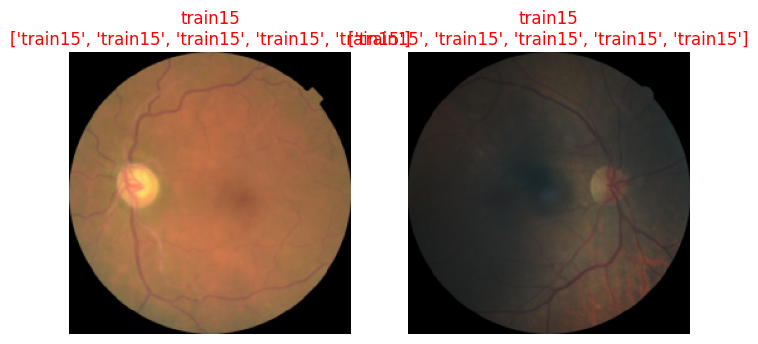

In [ ]:
learn.show_results(max_n=9, figsize=(8, 8))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Custom function to generate a report after training
def evaluate_model(learner, dl):
    preds, targs = learner.get_preds(dl=dl)
    preds = preds.argmax(dim=1).cpu().numpy()
    targets = targs.cpu().numpy()

    # Accuracy
    acc = accuracy_score(targets, preds)
    print(f"Accuracy: {acc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(targets, preds, zero_division=1))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(targets, preds))

    micro_precision = precision_score(targets, preds, average='micro')
    micro_recall = recall_score(targets, preds, average='micro')
    micro_f1 = f1_score(targets, preds, average='micro')

    macro_precision = precision_score(targets, preds, average='macro')
    macro_recall = recall_score(targets, preds, average='macro')
    macro_f1 = f1_score(targets, preds, average='macro')

    print("\nMicro and Macro Averages:")
    print(f"Micro Precision: {micro_precision:.4f}")
    print(f"Micro Recall: {micro_recall:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall: {macro_recall:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")

# Call this function after training, passing the validation dataloader
evaluate_model(learn, dls.valid)

Accuracy: 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       2.0
           3       0.00      1.00      0.00       0.0
           4       0.00      1.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.33      0.67      0.00       2.0
weighted avg       1.00      0.00      0.00       2.0


Confusion Matrix:
[[0 1 1]
 [0 0 0]
 [0 0 0]]

Micro and Macro Averages:
Micro Precision: 0.0000
Micro Recall: 0.0000
Micro F1 Score: 0.0000
Macro Precision: 0.0000
Macro Recall: 0.0000
Macro F1 Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Save the state_dict (model parameters)
torch.save(model, "models/v4.5_efficientnet-b7_model.pt")
torch.save(model, "models/v4.5_efficientnet-b7_model.pth")
torch.save(model, "models/v4.5_efficientnet-b7_model.pkl")